<a href="https://colab.research.google.com/github/ik-ingkarat/229352-StatisticalLearning/blob/main/Lab11_Fine_Tuning_Reasoning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #11

# Fine-Tuning Qwen3 for Thai Text Reasoning

Today, you will learn how to take a pre-trained Large Language Model (LLM) and specialize it for **Thai text reasoning** using the [Thai Reasoning Dataset](https://huggingface.co/datasets/iapp/Thai-R1-Distill-SFT).

We will be using [**Unsloth**](https://docs.unsloth.ai/get-started/all-our-models) to speeds up finetuning and reduces memory usage, making it possible to train in Google Colab.

If GPUs are not available in your Colab, you might want to try these two alternatives:
1. [Kaggle](https://www.kaggle.com)
2. [lightning.ai](https://lightning.ai)

If want learn gpt-2 ver.code [Donlap][https://github.com/donlap/ds352-labs/blob/main/Lab12_Transformers.ipynb]

### Installation

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2

### Fine-tuning Qwen3 with Unsloth

#### Transformer in Qwen3 vs GPT-2
<img src="https://substackcdn.com/image/fetch/$s_!GGk9!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa8fa602a-aa4d-4526-9252-c2f09dd5de92_1871x1920.png" alt="transformers" width="600"/>

[Source: [Sebastian Raschka](https://magazine.sebastianraschka.com/p/qwen3-from-scratch)]

In [ ]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-14B",
    max_seq_length = 2048,   # Context length - can be longer, but uses more memory
    load_in_4bit = True,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.7: Fast Qwen3 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.59G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

#### Low-Rank Adaptation (LoRA)
<img src="https://substackcdn.com/image/fetch/$s_!LXL5!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F7ab94b67-4efa-45e2-9a77-3121d6c88c45_1284x364.png" alt="LoRA" width="600"/>

[Source: [Dasha Herrmannova](https://oneminutenlp.com/p/low-rank-adaptation)]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Unsloth 2025.9.7 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


<a name="Data"></a>
### Data Prep
Use the [Thai Reasoning Dataset](https://huggingface.co/datasets/iapp/Thai-R1-Distill-SFT) provided by [iApp Technology](https://iapp.co.th/).

In [ ]:
from datasets import load_dataset
reasoning_dataset = load_dataset("iapp/Thai-R1-Distill-SFT", split = "train")

README.md:   0%|          | 0.00/231 [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Let's see the structure of both datasets:

In [ ]:
reasoning_dataset

Dataset({
    features: ['reannotated_assistant_content', 'problem', 'solution', 'id', 'source', 'verified', 'quality_metrics'],
    num_rows: 10000
})

We now convert the reasoning dataset into conversational format:

In [ ]:
def generate_conversation(examples):
    problems  = examples["problem"]
    solutions = examples["reannotated_assistant_content"]
    conversations = []
    for problem, solution in zip(problems, solutions):
        conversations.append([
            {"role" : "user",      "content" : problem},
            {"role" : "assistant", "content" : solution},
        ])
    return { "conversations": conversations, }

In [ ]:
reasoning_conversations = tokenizer.apply_chat_template(
    reasoning_dataset.map(generate_conversation, batched = True)["conversations"],
    tokenize = False,
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Let's see the first transformed row:

In [ ]:
reasoning_conversations[0]

'<|im_start|>user\nมีเด็กชาย 27 คนและเด็กหญิง 35 คนอยู่ในสนามเด็กเล่นในช่วงพัก มีเด็ก _____ คนอยู่ในสนามเด็กเล่นในช่วงพัก<|im_end|>\n<|im_start|>assistant\n<think>\nก่อนอื่น ฉันต้องคำนวณจำนวนเด็กทั้งหมดในสนามเด็กเล่นโดยนำจำนวนเด็กชายและเด็กหญิงมาบวกกัน มีเด็กชาย 27 คนและเด็กหญิง 35 คน เมื่อบวกกันแล้ว เด็กชาย 27 คน + เด็กหญิง 35 คน = เด็ก 62 คน ดังนั้น จำนวนเด็กทั้งหมดในสนามเด็กเล่นคือ 62 คน\n</think>\n\n ในการหาจำนวนเด็กทั้งหมดในสนามเด็กเล่น เราเพียงแค่บวกจำนวนเด็กชายและเด็กหญิงเข้าด้วยกัน \\[ \\text{จำนวนเด็กทั้งหมด} = \\text{จำนวนเด็กชาย} + \\text{จำนวนเด็กหญิง} \\] แทนค่าที่กำหนด: \\[ \\text{จำนวนเด็กทั้งหมด} = 27 \\text{ เด็กชาย} + 35 \\text{ เด็กหญิง} = 62 \\text{ เด็ก} \\] **คำตอบสุดท้าย:** \\[ \\boxed{62} \\]<|im_end|>\n'

In [ ]:
print(len(reasoning_conversations))

10000


In [ ]:
import pandas as pd

data = pd.Series(reasoning_conversations)
data.name = "text"

from datasets import Dataset
prepared_dataset = Dataset.from_pandas(pd.DataFrame(data))
prepared_dataset = prepared_dataset.shuffle(seed = 3407)

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

In [ ]:
import gc
from trl import SFTTrainer, SFTConfig

# Free some memory
gc.collect()
torch.cuda.empty_cache()

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = prepared_dataset,
    eval_dataset = None, # Can set up evaluation!
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 15,
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/10000 [00:00<?, ? examples/s]

Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,000 | Num Epochs = 1 | Total steps = 15
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 128,450,560 of 14,896,757,760 (0.86% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,0.779200
2,0.762300
3,0.630700
4,0.587800
5,0.661200
6,0.565100
7,0.578800
8,0.447900
9,0.506600
10,0.504600


<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

In [ ]:
FastLanguageModel.for_inference(model)

messages = [
    {"role" : "user", "content" : "จงหาจำนวนเต็ม x และ y ทั้งหมดที่ x^2 - y^2 = 5"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True, # Disable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1024, # Increase for longer outputs!
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<think>
โอเค ฉันต้องหาจำนวนเต็ม x และ y ทั้งหมดที่ทำให้สมการ x² - y² = 5 เป็นจริง ฉันรู้ว่า x² - y² สามารถแยกตัวประกอบได้เป็น (x - y)(x + y) ดังนั้น สมการที่กำหนดจึงกลายเป็น (x - y)(x + y) = 5 ตอนนี้ 5 เป็นจำนวนเฉพาะ ดังนั้น ตัวประกอบของมันจึงเป็น 1 และ 5 หรือ -1 และ -5 ฉันต้องพิจารณาทั้งสองกรณี: กรณี 1: x - y = 1 และ x + y = 5 ฉันสามารถแก้ระบบเหล่านี้เพื่อหา x และ y ได้โดยการเพิ่มสมการทั้งสอง: (x - y) + (x + y) = 1 + 5 → 2x = 6 → x = 3 เมื่อแทนค่า x = 3 ลงในสมการ x - y = 1: 3 - y = 1 → y = 2 ดังนั้น หนึ่งในคำตอบคือ x = 3 และ y = 2 กรณี 2: x - y = -1 และ x + y = -5 ฉันจะแก้ระบบเหล่านี้ได้โดยการเพิ่มสมการทั้งสอง: (x - y) + (x + y) = -1 + (-5) → 2x = -6 → x = -3 เมื่อแทนค่า x = -3 ลงในสมการ x - y = -1: -3 - y = -1 → y = -2 ดังนั้น อีกคำตอบหนึ่งคือ x = -3 และ y = -2 ดังนั้น จำนวนเต็ม x และ y ทั้งหมดที่ทำให้สมการ x² - y² = 5 เป็นจริงคือ (3, 2) และ (-3, -2) ฉันตรวจสอบคำตอบทั้งสอง: สำหรับ (3, 2): 3² - 2² = 9 - 4 = 5 สำหรับ (-3, -2): (-3)² - (-2)² = 9 - 4 = 5 ทั้งสองคำตอบถูกต้อง ดังนั้น คำตอบ

### Exercise 1: Ask the model a challenging math problem. You may increase the value of `max_new_tokens` if the model's answer is too short. Does the model solve your problem correctly?

In [ ]:
### YOUR CODE HERE ###
messages = [
    {"role" : "user", "content" : "จงหาจำนวนเต็ม x และ y ทั้งหมดที่ x^2 - y^2 = 5"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True, # Disable thinking
)

_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 128, # Increase for longer outputs!
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)


<think>
โอเค ฉันต้องหาจำนวนเต็ม x และ y ทั้งหมดที่ทำให้สมการ x² - y² = 5 เป็นจริง นี่คือวิธีที่ฉันคิด ฉันรู้ว่า x² - y² สามารถแยกตัวประกอบได้เป็น (x - y)(x + y) ดังนั้น สมการจึงกลายเป็น (x - y)(x + y) = 5 ตอนนี้ ฉันต้องหาคู่ของ


**Answer to Exercise 1**

- หากคำตอบของแบบจำลองสั้นเกินไป แบบจำลองแก้ปัญหาได้อย่างถูกต้อง เพียงแต่คำตอบขาดหาย

### Visualizing Attention

### Exercise 2: Fill in the ##TODO## part in the `visualize_attention()` function below to calculate the product between the query matrix `Q` and the key matrix `K`.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the helper function to perform the rotation
def rotate_half(x):
    """Rotates half the hidden dimensions of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

# Define a global dictionary to store the attention matrix
attention_viz_data = {}

def visualize_attention(model, tokenizer, prompt, layer_number):
    """
    Visualizes the QK^T attention matrix for a given prompt and layer,

    Args:
        model: The Unsloth Qwen3 14B model.
        tokenizer: The tokenizer for the model.
        prompt (str): The input text prompt.
        layer_number (int): The decoder layer number to visualize.
    """
    attention_viz_data.clear()

    # 1. Get a reference to the specific attention layer
    try:
        attention_layer = model.base_model.model.model.layers[layer_number].self_attn
    except AttributeError as e:
        print(f"Could not find the specified layer. Please double-check the model architecture path. Error: {e}")
        return

    # 2. Store the original forward method
    original_forward = attention_layer.forward

    def new_forward(self, hidden_states, *args, **kwargs):
        """A new forward method to capture the QK^T matrix."""

        bsz, q_len, _ = hidden_states.size()

        # Project to Q, K
        Q_all_heads = self.q_proj(hidden_states)
        K_all_heads = self.k_proj(hidden_states)

        # Reshape for multi-head attention. Note the different head counts.
        Q_all_heads = Q_all_heads.view(bsz, q_len, self.config.num_attention_heads, self.head_dim).transpose(1, 2)
        K_all_heads = K_all_heads.view(bsz, q_len, self.config.num_key_value_heads, self.head_dim).transpose(1, 2)

        # Get rotary embeddings
        cos, sin = self.rotary_emb(K_all_heads, seq_len=q_len)

        # Apply rotary embeddings directly
        Q_all_heads = (Q_all_heads * cos) + (rotate_half(Q_all_heads) * sin)
        K_all_heads = (K_all_heads * cos) + (rotate_half(K_all_heads) * sin)

        # Repeat the key heads to match the number of query heads.
        num_key_value_groups = self.config.num_attention_heads // self.config.num_key_value_heads
        if num_key_value_groups > 1:
            K_all_heads = K_all_heads.repeat_interleave(num_key_value_groups, dim=1)

        # Now, the dimensions match for matrix multiplication:
        # Q_all_heads: [1, 40, 29, 128] = [batch_size, num_heads, seq_len, head_dim]
        # K_all_heads: [1, 40, 29, 128] = [batch_size, num_heads, seq_len, head_dim]

        Q = Q_all_heads[0, 0]  # Query of the first head
        K = K_all_heads[0, 0]  # Key of the first head

        ########## TODO: CALCULATE QK^T ############
        attention = torch.matmul(Q, K.transpose(-1, -2))

        # Store the matrix for visualization
        attention_viz_data['qk_t'] = attention.detach()

        # Call the original forward method to ensure the model's computation continues normally
        return original_forward(hidden_states, *args, **kwargs)

    # 3. Monkey-patch the layer's forward method
    try:
        attention_layer.forward = new_forward.__get__(attention_layer, type(attention_layer))

        # 4. Prepare and run the model
        inputs = tokenizer(prompt, return_tensors="pt")
        input_ids = inputs.input_ids.to(model.device)

        with torch.no_grad():
            _ = model(input_ids)

    finally:
        # 5. Restore the original forward method
        attention_layer.forward = original_forward

    # 6. Visualize the captured data
    if 'qk_t' in attention_viz_data:
        # We visualize the scores for the first head of the first batch item
        qk_matrix = attention_viz_data['qk_t'].cpu().float().numpy()

        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        tokens = [token[1:] if token[0] == 'Ġ' else token for token in tokens]

        plt.figure(figsize=(12, 10))
        im = plt.imshow(qk_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar(im, label='Attention Score (Logits)')
        plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=90)
        plt.yticks(ticks=np.arange(len(tokens)), labels=tokens)
        plt.xlabel("Key Tokens")
        plt.ylabel("Query Tokens")
        plt.title(f"QK^T Matrix Visualization for Layer {layer_number}, Head 0")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Failed to capture the QK^T matrix for layer {layer_number}.")

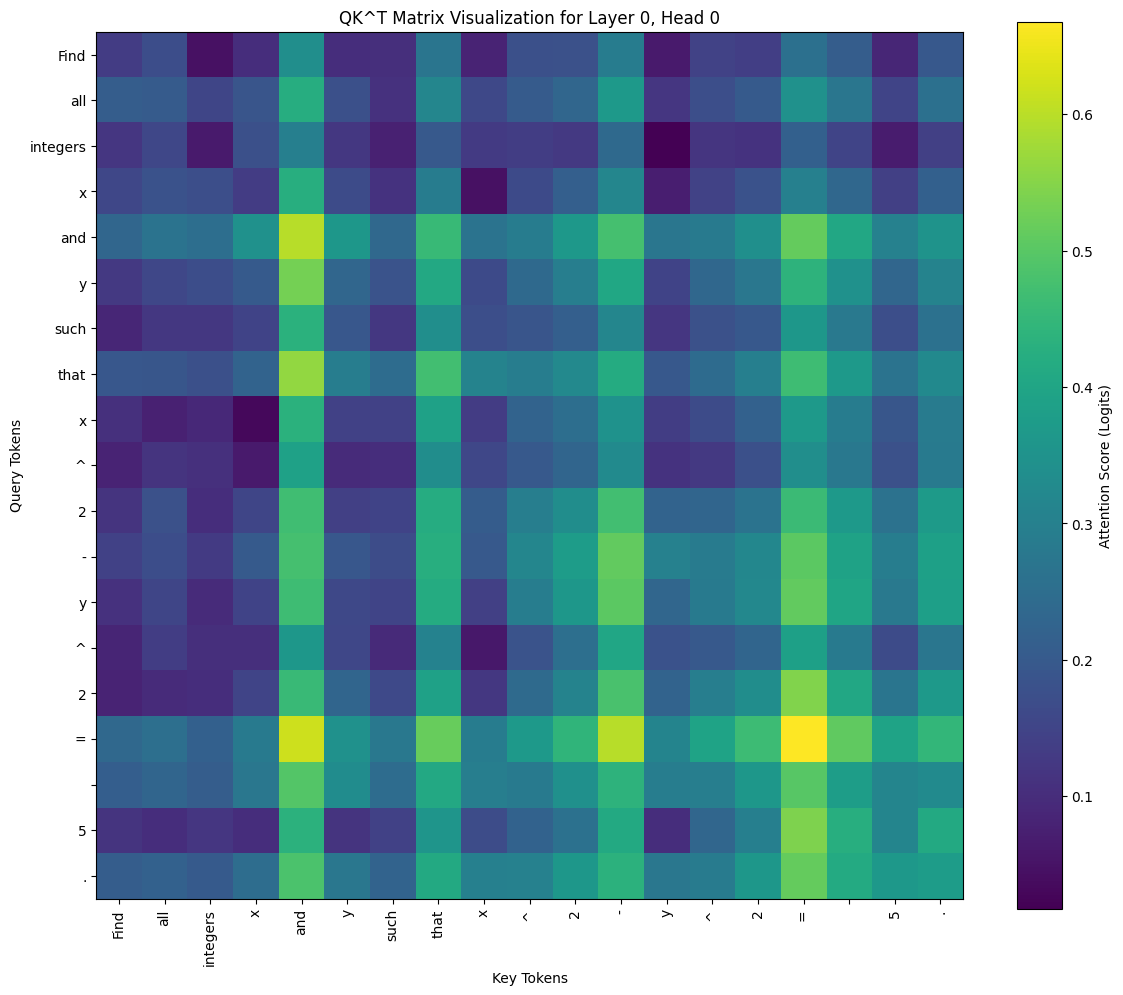

In [ ]:
example_text = "Find all integers x and y such that x^2 - y^2 = 5."

visualize_attention(model, tokenizer, example_text, 0)

### Exercise 3: Choose your own example text. Find **two** pairs of two distinct words with the highest attention values. Why do you think those two pairs have the highest attention values?

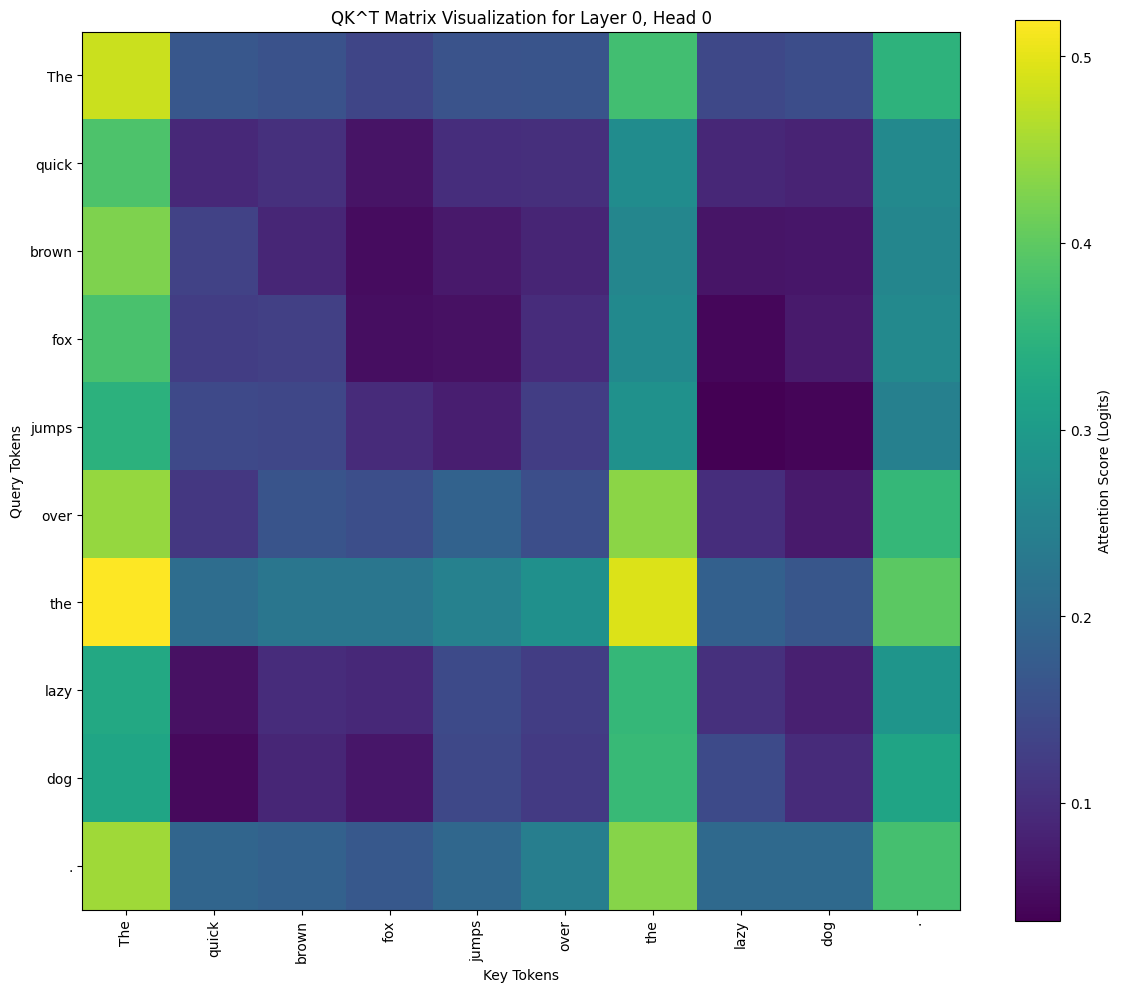

In [ ]:
### YOUR CODE HERE ###

example_text = "The quick brown fox jumps over the lazy dog."

visualize_attention(model, tokenizer, example_text, 0)


**Answers to Exercise 3**

- จะเห็นว่าคำว่า "the"กับ"The" จะมีค่่าattention valuesที่สูงด้วยกันเพราะ คำเดียวกัน และรองลงมา "The"กับ"." อาจเป็นเพราะเป็นตัวที่ขึ้นต้นประโยคและจบประโยค

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/chat_template.jinja',
 'lora_model/vocab.json',
 'lora_model/merges.txt',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        load_in_4bit = True,
    )

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False: # Pushing to HF Hub
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")
